In [1]:
# What version of Python do you have?
%matplotlib inline
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow.keras
import pandas as pd
import sklearn as sk
import tensorflow as tf
import keras

# Check if everything alright with tensorflow
print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

Init Plugin
Init Graph Optimizer
Init Kernel
Tensor Flow Version: 2.5.0
Keras Version: 2.5.0

Python 3.9.13 | packaged by conda-forge | (main, May 27 2022, 17:00:33) 
[Clang 13.0.1 ]
Pandas 1.4.4
Scikit-Learn 1.1.2
GPU is available


# Data Pipeline
## Load data in batches

In [125]:
data = tf.keras.preprocessing.image_dataset_from_directory('data', image_size=(250,250))

Found 427 files belonging to 2 classes.


In [126]:
data_iterator = data.as_numpy_iterator()

In [127]:
batch = data_iterator.next()

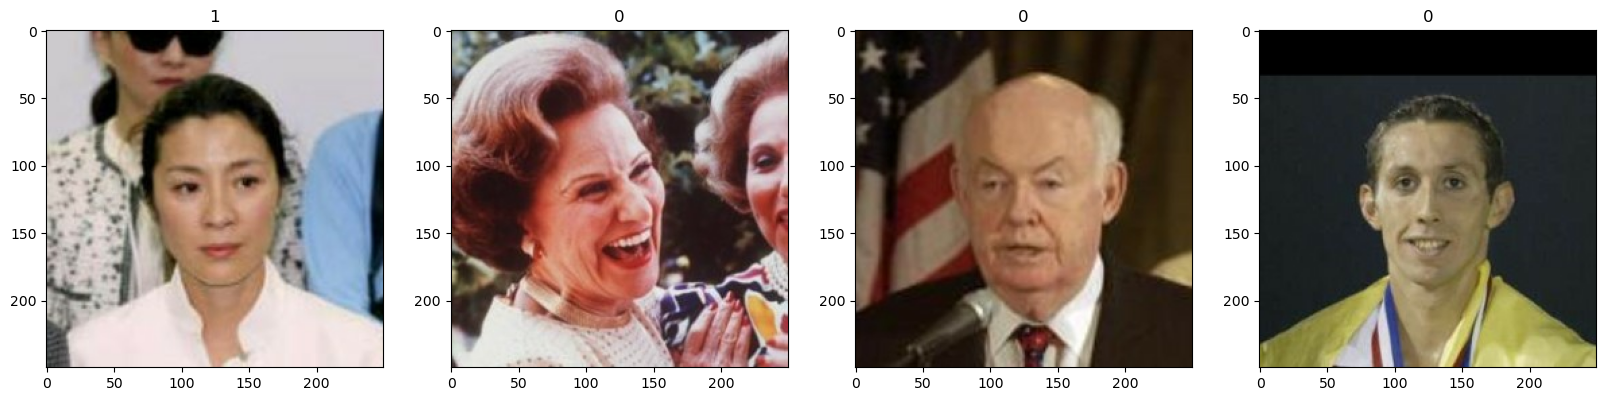

In [128]:
# Class 1 = LIKE
# Class 0 = DISLIKE
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# Preproccess Data
## Scaling Images

In [129]:
data = data.map(lambda x,y: (x/255,y))

In [130]:
preprocessed_date = data.as_numpy_iterator()

In [131]:
preporcessed_batch = preprocessed_date.next()

In [132]:
print(preporcessed_batch[0].min(), preporcessed_batch[0].max())

0.0 1.0


## Partitioning the dataset

In [133]:
len(data)

14

In [134]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)+1
test_size = int(len(data)*.1)+1

In [135]:
train_size + val_size + test_size

14

In [136]:
train_data = data.take(train_size)
val_data = data.skip(train_size).take(val_size)
test_data = data.skip(train_size+val_size).take(test_size)

# Building the model

## Loading base model

In [14]:
# Import inception model
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [62]:
base_model = InceptionV3(input_shape = (250,250,3), # Shape of images
                                include_top = False,
                                weights = 'imagenet')

In [63]:
base_model.trainable = False

In [17]:
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 250, 250, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 124, 124, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 124, 124, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 124, 124, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

## Creating labelling layer and applying to base model

In [64]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

In [65]:
prediction_layer = keras.layers.Dense(1, activation='sigmoid')

In [137]:
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

In [139]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [140]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 6, 6, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
module_wrapper_2 (ModuleWrap (None, 1)                 2049      
Total params: 21,804,833
Trainable params: 2,049
Non-trainable params: 21,802,784
_________________________________________________________________


## Train model

In [69]:
LOG_DIR = 'logs'

In [70]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=LOG_DIR)

2022-09-19 18:55:19.638511: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-09-19 18:55:19.638569: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2022-09-19 18:55:19.638928: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.


In [141]:
hist = model.fit(train_data, epochs=20, validation_data=val_data, callbacks=[tensorboard_callback])

Epoch 1/20


2022-09-19 19:22:34.391810: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


2/9 [=====>........................] - ETA: 6s - loss: 0.1831 - accuracy: 0.9062 

2022-09-19 19:22:36.228587: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-09-19 19:22:36.228606: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.


3/9 [=========>....................] - ETA: 7s - loss: 0.1797 - accuracy: 0.9062

2022-09-19 19:22:37.750979: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-09-19 19:22:37.751695: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2022-09-19 19:22:37.752850: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/train/plugins/profile/2022_09_19_19_22_37
2022-09-19 19:22:37.753986: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_09_19_19_22_37/Eduardos-MBP.trace.json.gz
2022-09-19 19:22:37.754492: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/train/plugins/profile/2022_09_19_19_22_37
2022-09-19 19:22:37.754632: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for memory_profile.json.gz to logs/train/plugins/profile/2022_09_19_19_22_37/Eduardos-MBP.memory_profile.json.gz
2022-09-19 19:22:37.755036: I t

9/9 [==============================] - ETA: 0s - loss: 0.1960 - accuracy: 0.9201

2022-09-19 19:22:38.963441: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


9/9 [==============================] - 7s 532ms/step - loss: 0.1960 - accuracy: 0.9201 - val_loss: 0.2586 - val_accuracy: 0.8646
Epoch 2/20
9/9 [==============================] - 2s 175ms/step - loss: 0.1853 - accuracy: 0.9236 - val_loss: 0.1370 - val_accuracy: 0.9375
Epoch 3/20
9/9 [==============================] - 2s 176ms/step - loss: 0.1743 - accuracy: 0.9236 - val_loss: 0.2008 - val_accuracy: 0.9167
Epoch 4/20
9/9 [==============================] - 2s 175ms/step - loss: 0.1733 - accuracy: 0.9340 - val_loss: 0.2094 - val_accuracy: 0.9062
Epoch 5/20
9/9 [==============================] - 2s 176ms/step - loss: 0.1652 - accuracy: 0.9375 - val_loss: 0.1840 - val_accuracy: 0.9375
Epoch 6/20
9/9 [==============================] - 2s 173ms/step - loss: 0.1833 - accuracy: 0.9271 - val_loss: 0.1769 - val_accuracy: 0.9271
Epoch 7/20
9/9 [==============================] - 2s 173ms/step - loss: 0.1515 - accuracy: 0.9514 - val_loss: 0.1822 - val_accuracy: 0.9375
Epoch 8/20
9/9 [===============

## Performance

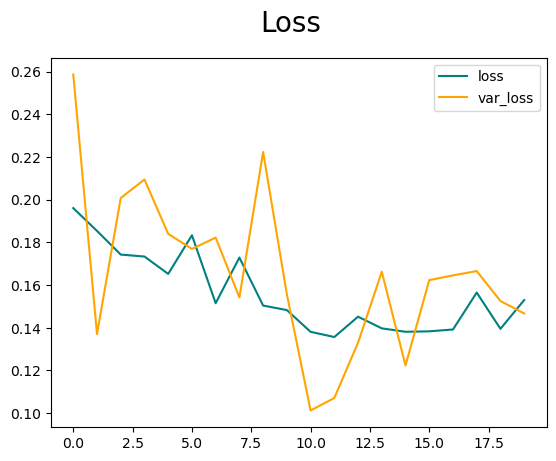

In [142]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='var_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend()
plt.show()

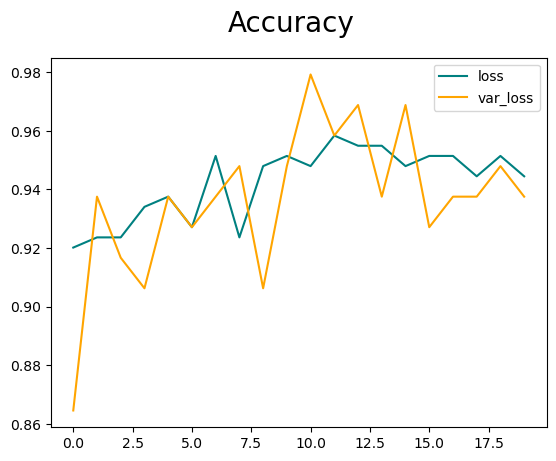

In [143]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='loss')
plt.plot(hist.history['val_accuracy'], color='orange', label='var_loss')
fig.suptitle('Accuracy', fontsize=20)
plt.legend()
plt.show()

## Evaluate Performance

In [28]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [144]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [145]:
for batch in test_data.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

2022-09-19 19:23:29.063506: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-09-19 19:23:29.832414: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [146]:
precision = np.round(pre.result().numpy()*100,2)
recall = np.round(re.result().numpy()*100,2)
accuracy = np.round(acc.result().numpy()*100,2)
print(f'Precision:{precision}%, Recall:{recall}%, Accuracy:{accuracy}%')

Precision:100.0%, Recall:50.0%, Accuracy:89.35%


## Test

In [32]:
import cv2

In [150]:
test_file = 'scarlet.jpeg'

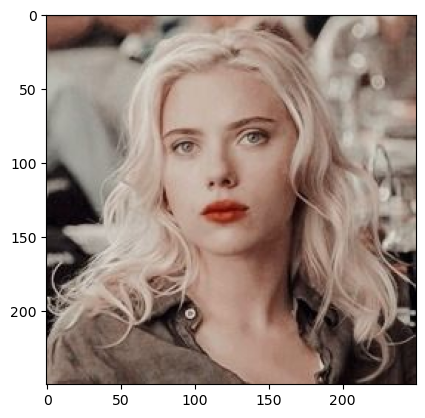

In [151]:
img = cv2.imread(test_file)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [152]:
yhat = model.predict(np.expand_dims(img/255,0))
if yhat > 0.5:
    print(f'You will LIKE this person, probability = {np.round(yhat[0][0]*100,2)}%')
else:
    print(f'You will DISLIKE this person, probability = {100-np.round(yhat[0][0]*100,2)}%')

You will LIKE this person, probability = 94.1%
